# Forecasting DSMarket

## Objetivo

*   Desarrollar un nuevo enfoque de pronóstico para casos de uso que dependen de la precisión del pronóstico (modelo predictivo).

*   Confirme si su enfoque es válido: generalmente comienzan prediciendo las ventas a nivel de tienda-producto y, para obtener ventas agregadas por departamento/tienda/ciudad, suman predicciones independientes. Comience con predicciones de 28 días (4 semanas).

*   Utilice el formato de salida que me enviaron para evaluar modelos.

In [ ]:
# imports time series
import pandas as pd
import numpy as np
import time

# plots
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import seaborn as sns


# para calculas métricas del modelo
from sklearn.metrics import mean_squared_error

# misc
import os
import time
import itertools
import warnings
warnings.filterwarnings("ignore")

# apartado ts
!pip install statsmodels
!pip install xgboost
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt
from sklearn.model_selection import GridSearchCV
import xgboost as xgb


!pip install prophet
from prophet import Prophet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_PATH = os.path.join("/content/drive/MyDrive/Nuclio/Notebooks/CapstoneProject/CSVs/DatosAgrupadosEnSemanas.csv.gz")

In [ ]:
df = pd.read_csv(DATA_PATH)

In [ ]:
df.head()

,id,item,category,department,store,store_code,region,año,semana,trimestre,event,ventas,yearweek,sell_price
0,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011,4,1,Sin_Evento,0,201104,12.74
1,ACCESORIES_1_002_BOS_1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011,4,1,Sin_Evento,0,201104,5.28
2,ACCESORIES_1_003_BOS_1,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011,4,1,Sin_Evento,0,201104,3.95
3,ACCESORIES_1_004_BOS_1,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011,4,1,Sin_Evento,3,201104,5.77
4,ACCESORIES_1_005_BOS_1,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011,4,1,Sin_Evento,0,201104,3.63


In [ ]:
# Convertiremos la columna de "yearweek" a formato datetime para realizar tareas de forecasting
# para ello necesitamos que la columna este en formato string primero y despues la cambiaremos a Datetime
df['yearweek'] = df['yearweek'].astype(str)

# Convertir 'yearweek' a datetime usando el primer día de la semana
df['date'] = pd.to_datetime(df['yearweek'] + '1', format='%Y%W%w')  # El 1 agrega el primer día de la semana (lunes)

# Mostrar el DataFrame con la nueva columna de fechas
df.head()

,id,item,category,department,store,store_code,region,año,semana,trimestre,event,ventas,yearweek,sell_price,date
0,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011,4,1,Sin_Evento,0,201104,12.74,2011-01-24
1,ACCESORIES_1_002_BOS_1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011,4,1,Sin_Evento,0,201104,5.28,2011-01-24
2,ACCESORIES_1_003_BOS_1,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011,4,1,Sin_Evento,0,201104,3.95,2011-01-24
3,ACCESORIES_1_004_BOS_1,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011,4,1,Sin_Evento,3,201104,5.77,2011-01-24
4,ACCESORIES_1_005_BOS_1,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011,4,1,Sin_Evento,0,201104,3.63,2011-01-24


##EDA del dataset

In [ ]:
df['id'].nunique()

30490

In [ ]:
df['date'].nunique()

273

In [ ]:
df['department'].unique()

array(['ACCESORIES_1', 'ACCESORIES_2', 'HOME_&_GARDEN_1',
       'HOME_&_GARDEN_2', 'SUPERMARKET_1', 'SUPERMARKET_2',
       'SUPERMARKET_3'], dtype=object)

In [ ]:
df['category'].unique()

array(['ACCESORIES', 'HOME_&_GARDEN', 'SUPERMARKET'], dtype=object)

In [ ]:
df['item'].nunique() # Tenemos 3049 items unicos con los que hacer timeseries

3049

In [ ]:
# Contar cuántas tiendas únicas hay en cada región
stores_por_region = df.groupby('region')['store'].unique().apply(list)
# Mostrar el resultado
print(stores_por_region)

region
Boston                          [South_End, Roxbury, Back_Bay]
New York        [Greenwich_Village, Harlem, Tribeca, Brooklyn]
Philadelphia        [Midtown_Village, Yorktown, Queen_Village]
Name: store, dtype: object


In [ ]:
MIN_DATE = df["date"].min()
MAX_DATE = df["date"].max()
print(f"Min date is {MIN_DATE}\nMax date is {MAX_DATE}")

Min date is 2011-01-24 00:00:00
Max date is 2016-04-18 00:00:00


In [ ]:
# Nuevo orden de las columnas. Al no reindexar la columna "yearweek" desaparece del datasset
orden_columns = ['id','item','category','department','store','region','store_code','event','date','semana','trimestre','año','ventas','sell_price']

# Reordenar el DataFrame usando reindex
df = df.reindex(columns=orden_columns)

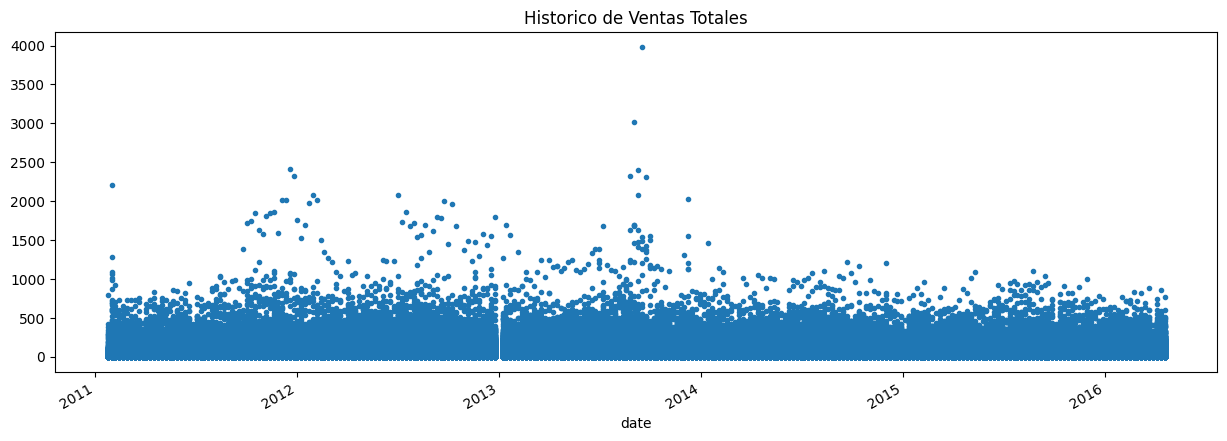

In [ ]:
df.set_index("date")["ventas"].plot(style= ".", figsize=(15,5), title= "Historico de Ventas Totales" )
plt.show()

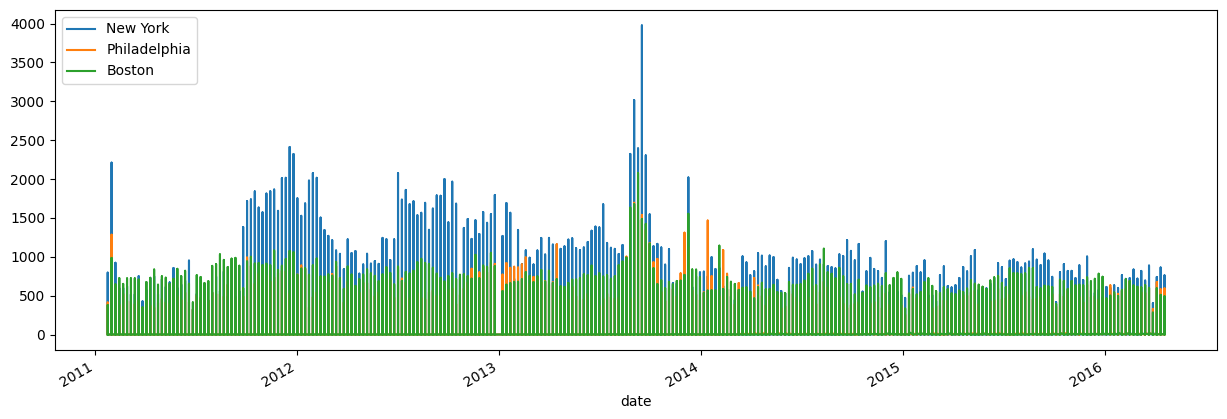

In [ ]:
#Historico por region
ny = df[df["region"] == "New York"].set_index("date")["ventas"]
ph = df[df["region"] == "Philadelphia"].set_index("date")["ventas"]
bos = df[df["region"] == "Boston"].set_index("date")["ventas"]

fig, ax = plt.subplots(figsize=(15, 5))
ny.plot(ax = ax, label = "New York")
ph.plot(ax = ax, label = "Philadelphia")
bos.plot(ax = ax, label = "Boston")
ax.legend(loc = "upper left")

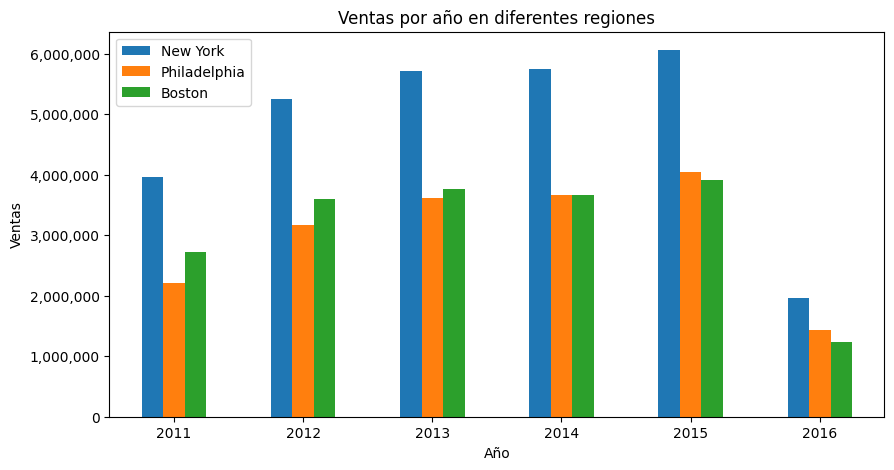

In [ ]:
# Agrupar las ventas por año para cada región
ny = df[df["region"] == "New York"].groupby('año')["ventas"].sum()
ph = df[df["region"] == "Philadelphia"].groupby('año')["ventas"].sum()
bos = df[df["region"] == "Boston"].groupby('año')["ventas"].sum()

# Crear un DataFrame combinado para facilitar el gráfico
df_combined = pd.DataFrame({
    "New York": ny,
    "Philadelphia": ph,
    "Boston": bos
})

# Graficar las barras
fig, ax = plt.subplots(figsize=(10, 5))
df_combined.plot(kind='bar', ax=ax)

# Configurar leyenda y etiquetas
ax.set_ylabel('Ventas')
ax.set_xlabel('Año')
ax.set_title('Ventas por año en diferentes regiones')
plt.xticks(rotation=0)
ax.legend(loc="upper left")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
# Mostrar gráfico
plt.show()

In [ ]:
def plot_ts_acf_pacf(y, title):
    '''
    Plots the ts you pass and the acf and pacf.
    Plotea los graficos para identificar
    '''
    fig = plt.figure(figsize = (12, 10))
    ax1, ax2, ax3 = fig.subplots(3, 1)

    ax1.plot(y)
    ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: int(x)))  # Formato de enteros para el eje Y
    plot_acf(x = y, ax = ax2, lags = 14)
    plot_pacf(x = y, ax = ax3, lags = 14)

    plt.suptitle(t = title, fontsize = 20)

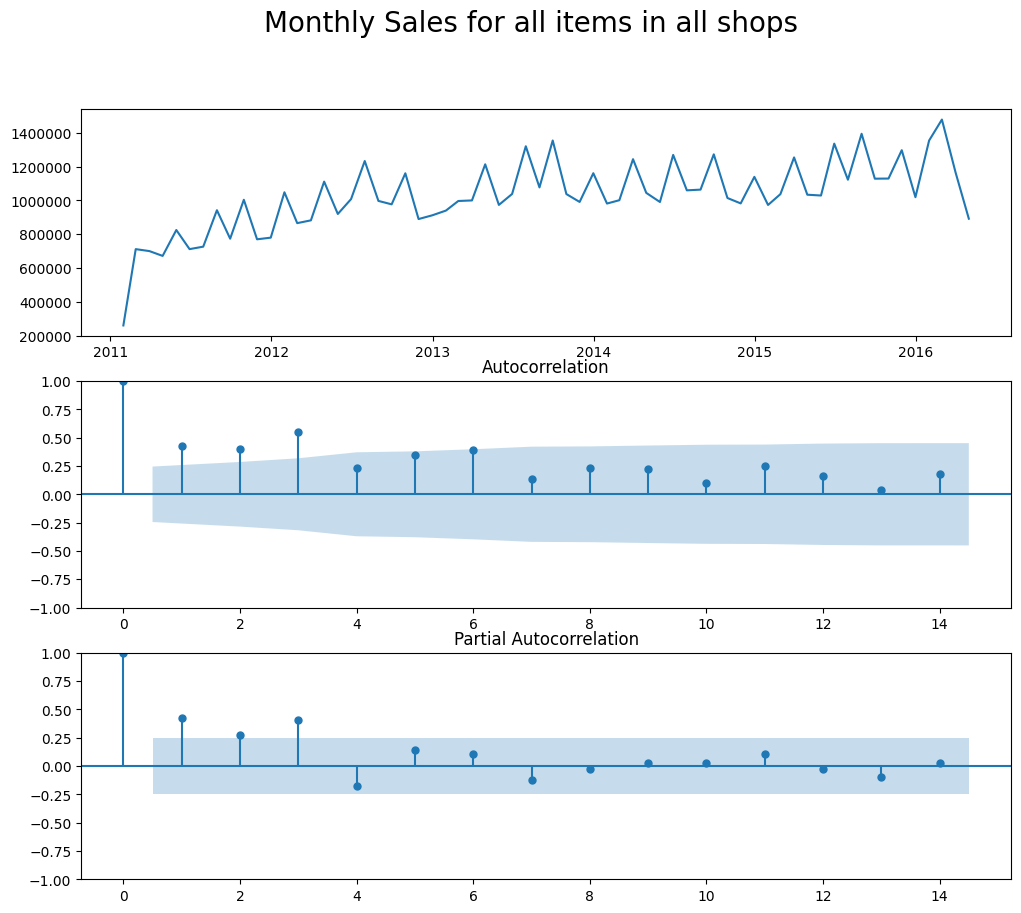

In [ ]:
y = df.set_index("date").resample("M")["ventas"].sum()
plot_ts_acf_pacf(y = y, title = "Monthly Sales for all items in all shops");

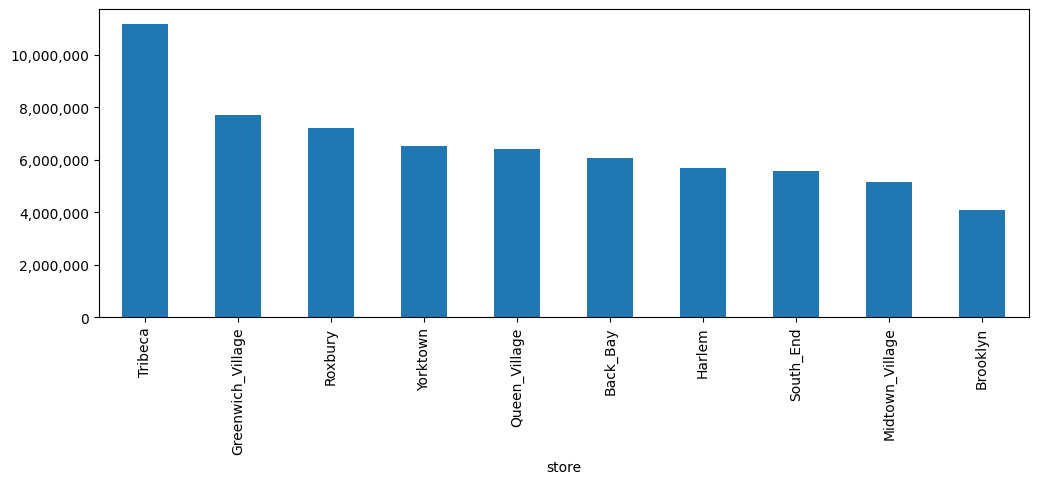

In [ ]:
(
    df.
    groupby(["store"])
    ["ventas"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);
ax = plt.gca()  # Obtener los ejes actuales
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.show()

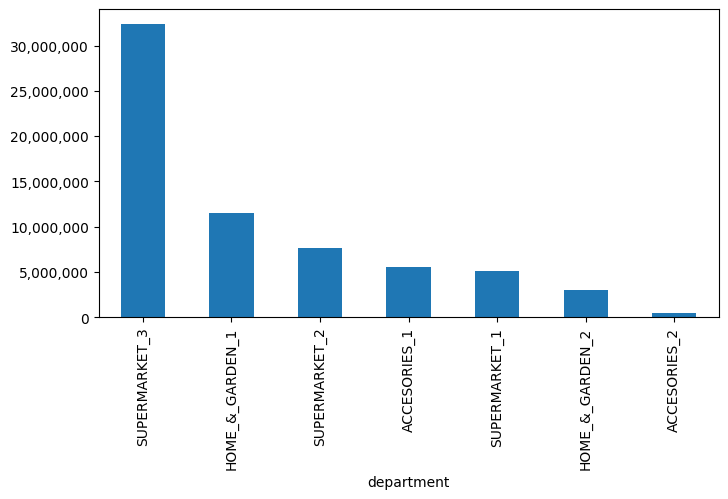

In [ ]:
(
    df.
    groupby(["department"])
    ["ventas"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (8, 4))
);
ax = plt.gca()  # Obtener los ejes actuales
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.show()

##Adaptamos el dataset al objetivo de la tarea

In [ ]:
df2 = df.copy()

In [ ]:
df2['revenue']=df2['ventas'] * df2['sell_price'] #creamos la variable revenue (facturación)

In [ ]:
# utiliza ultimo caracter de department

df2['department'] = df2['department'].str[-1].astype(int)

In [ ]:
df2['item'] = df2['item'].str[-3:].astype(int) #Nos quedamos con el numero del item

In [ ]:
# Vamos a prescindir de diferentes colummnas ya que existen otras mas relevantes o estan formadas por la
# agregacion de otras existentes.
cols_drop= ['store_code']

In [ ]:
df2.drop(cols_drop, axis=1,inplace=True)

In [ ]:
# Definir el mapeo manual
region_mapping = {
    'New York': 1,
    'Philadelphia': 2,
    'Boston': 3
}

# Asignar el orden numérico manualmente
df2['region'] = df2['region'].map(region_mapping).astype("int64")

In [ ]:
# Definir el mapeo manual
store_mapping = {
    'Greenwich_Village': 0,
    'Harlem': 1,
    'Tribeca': 2,
    'Brooklyn': 3,
    'Midtown_Village': 4,
    'Yorktown': 5,
    'Queen_Village': 6,
    'South_End': 7,
    'Roxbury': 8,
    'Back_Bay': 9,
}

# Asignar el orden numérico manualmente a la columna 'store'
df2['store'] = df2['store'].map(store_mapping).astype("int64")

In [ ]:
# Definir el mapeo manual
dptm_mapping = {
    'ACCESORIES': 0,
    'HOME_&_GARDEN': 1,
    'SUPERMARKET': 2

}

# Asignar el orden numérico manualmente a la columna 'store'
df2['category'] = df2['category'].map(dptm_mapping).astype("int64")

In [ ]:
# Definir el mapeo manual
eve_mapping = {
    'Sin_Evento': 0,
    'SuperBowl': 1,
    'Ramadan starts': 2,
    'Thanksgiving': 3,
    'NewYear': 4,
    'Easter': 5
}

# Asignar el orden numérico manualmente a la columna 'store'
df2['event'] = df2['event'].map(eve_mapping).astype("int64")

Creamos las 4 semanas extras que necesitamos de mayo para hacer la prediccion

In [ ]:
df3 = df2.copy()

In [ ]:
last_date = df3["date"].max()

# Generamos nuevas fechas
new_dates = pd.date_range(start=last_date + pd.Timedelta(days=7), periods=4, freq="W-MON")

In [ ]:
new_dates

DatetimeIndex(['2016-04-25', '2016-05-02', '2016-05-09', '2016-05-16'], dtype='datetime64[ns]', freq='W-MON')

In [ ]:
last_records = df3.groupby('id').last().reset_index()

In [ ]:
new_rows = last_records.loc[last_records.index.repeat(len(new_dates))]
new_rows['date'] = list(new_dates) * len(last_records)
new_rows['ventas'] = 0
new_rows['revenue'] = 0
new_rows['semana'] = new_rows['date'].dt.isocalendar().week
new_rows['trimestre'] = new_rows['date'].dt.quarter
new_rows['año'] = new_rows['date'].dt.year

In [ ]:
df_future = pd.concat([df3, new_rows], ignore_index=True)

In [ ]:
df_future[df_future['id']=='SUPERMARKET_1_001_BOS_1'].tail(10)

,id,item,category,department,store,region,event,date,semana,trimestre,año,ventas,sell_price,revenue
8721752,SUPERMARKET_1_001_BOS_1,1,2,1,7,3,5,2016-03-21,12,1,2016,4,2.69,10.76
8753854,SUPERMARKET_1_001_BOS_1,1,2,1,7,3,0,2016-03-28,13,1,2016,0,2.69,0.00
8753855,SUPERMARKET_1_001_BOS_1,1,2,1,7,3,0,2016-03-28,13,2,2016,0,2.69,0.00
8813222,SUPERMARKET_1_001_BOS_1,1,2,1,7,3,0,2016-04-04,14,2,2016,1,2.69,2.69
8843712,SUPERMARKET_1_001_BOS_1,1,2,1,7,3,0,2016-04-11,15,2,2016,0,2.69,0.00
8874202,SUPERMARKET_1_001_BOS_1,1,2,1,7,3,0,2016-04-18,16,2,2016,0,2.69,0.00
8967560,SUPERMARKET_1_001_BOS_1,1,2,1,7,3,0,2016-04-25,17,2,2016,0,2.69,0.00
8967561,SUPERMARKET_1_001_BOS_1,1,2,1,7,3,0,2016-05-02,18,2,2016,0,2.69,0.00
8967562,SUPERMARKET_1_001_BOS_1,1,2,1,7,3,0,2016-05-09,19,2,2016,0,2.69,0.00
8967563,SUPERMARKET_1_001_BOS_1,1,2,1,7,3,0,2016-05-16,20,2,2016,0,2.69,0.00


In [ ]:
df_future.shape

(9025040, 14)

##Creacion de features

In [ ]:
df_it_st2 = df_future.copy()

In [ ]:
df_it_st2.head()

,id,item,category,department,store,region,event,date,semana,trimestre,año,ventas,sell_price,revenue
0,ACCESORIES_1_001_BOS_1,1,0,1,7,3,0,2011-01-24,4,1,2011,0,12.74,0.00
1,ACCESORIES_1_002_BOS_1,2,0,1,7,3,0,2011-01-24,4,1,2011,0,5.28,0.00
2,ACCESORIES_1_003_BOS_1,3,0,1,7,3,0,2011-01-24,4,1,2011,0,3.95,0.00
3,ACCESORIES_1_004_BOS_1,4,0,1,7,3,0,2011-01-24,4,1,2011,3,5.77,17.31
4,ACCESORIES_1_005_BOS_1,5,0,1,7,3,0,2011-01-24,4,1,2011,0,3.63,0.00


In [ ]:
# Fuente del descubrimiento: https://www.kaggle.com/code/lauraportell/future-sales-part-ii-model-training-2/notebook
class FeatureGenerator(object):
    '''
    Esto es una clase, nos servirá para montar una especie de "librería" de funciones
    propia para crear nuestras variables customizadas para mejorar nuestro dataset de TimeSeries.
    '''

    def __init__(self, full_df, gb_list):
        '''
        Se inicializa pasando un DataFrame y un listado de columnas las cuales nos servirán
        para generar nuevas variables. La última línea de esta función es para renombrar las
        columnas nuevas y añadirlas al DataFrame.
        '''
        self.full_df = full_df
        self.gb_list = gb_list
        self.objective_column_name = "_".join(gb_list)

    def generate_gb_df(self):
        '''
        Agrupamos el DataFrame original y calculamos sumas y medias de 'ventas' por cada grupo.
        El resultado es un DataFrame con características agregadas que pueden ayudar a identificar tendencias.
        '''
        def my_agg(full_df_, args):
            names = {
                '{}_sum'.format(args): full_df_['ventas'].sum(),
                '{}_mean'.format(args): full_df_['ventas'].mean(),
            }
            return pd.Series(names)

        # Aplicar la función agregada
        gb_df_ = self.full_df.groupby(self.gb_list).apply(my_agg, args=self.objective_column_name).reset_index()
        self.gb_df_ = gb_df_

    def generate_shift_features(self, suffix):
        '''
        Crea características retrasadas (lags) y variaciones de las mismas.
        '''
        name_ = self.objective_column_name + "_" + suffix

        for i in range(1, 4):
            # Crear la característica shift
            self.gb_df_['{}_shift_{}'.format(name_, i)] = self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda series: series.shift(i))

            # Crear la variación porcentual, solo para los primeros 3 lags
            self.gb_df_['{}_var_pct_{}'.format(name_, i)] = self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda series: (series - series.shift(i)) / series.shift(i))

        # Reemplazar NaN, inf, -inf
        self.gb_df_.fillna(-1, inplace=True)
        self.gb_df_.replace([np.inf, -np.inf], -1, inplace=True)

    def return_gb_df(self):
        '''
        Retorna el DataFrame con las características shift y variacion generadas.
        '''
        self.generate_shift_features(suffix="sum")
        self.generate_shift_features(suffix="mean")

        return self.gb_df_

In [ ]:

def crear_lag_features(df, gb_list):
    var_gen = FeatureGenerator(df, ['date'] + gb_list)
    var_gen.generate_gb_df()
    store_var_gen = var_gen.return_gb_df()
    df = pd.merge(df, store_var_gen, on=["date"] + gb_list, how="left")
    return df


In [ ]:
features_lags_params= [
    {   #Totales y lags de Tienda
        "gb_list" : ["store"],
    },
    {   #Totales y lags de
        "gb_list" : ["store","region"],
    },
    {   #Totales y lags de
        "gb_list" : ["store","category","department"],
    },
    {   #Totales y lags de Ciudad
        "gb_list" : ["region"],
    },
    {   #Totales y lags de
        "gb_list" : ["region","category","department"],
    },
    {   #Totales y lags de Departamento
        "gb_list" : ["category","department"],
    },



]

In [ ]:
start_time = time.time()

print(df_it_st2.shape)

n_var_old = len(df_it_st2.columns)

#Generar nuevas features
for params in features_lags_params:
    df_it_st2 = crear_lag_features(df_it_st2, params["gb_list"])

n_var_new = len(df_it_st2.columns)

end_time = time.time()
elapsed_time = end_time - start_time

print('-'*30)
print(df_it_st2.shape)
print(f"Se crearon {n_var_new - n_var_old} nuevas variables")
print(f"El tiempo de ejecución fue: {elapsed_time/60:.2f} minutos")
print('-'*30)

(9025040, 14)
------------------------------
(9025040, 98)
Se crearon 84 nuevas variables
El tiempo de ejecución fue: 0.99 minutos
------------------------------


In [ ]:
df_it_st2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9025040 entries, 0 to 9025039
Data columns (total 98 columns):
 #   Column                                          Dtype         
---  ------                                          -----         
 0   id                                              object        
 1   item                                            int64         
 2   category                                        int64         
 3   department                                      int64         
 4   store                                           int64         
 5   region                                          int64         
 6   event                                           int64         
 7   date                                            datetime64[ns]
 8   semana                                          Int64         
 9   trimestre                                       int64         
 10  año                                             int64         
 11

## Train/Test Split

In [ ]:
df_it_st3 =  df_it_st2.copy()

In [ ]:
df_it_st3.head(3)

,id,item,category,department,store,region,event,date,semana,trimestre,...,date_category_department_sum_shift_2,date_category_department_sum_var_pct_2,date_category_department_sum_shift_3,date_category_department_sum_var_pct_3,date_category_department_mean_shift_1,date_category_department_mean_var_pct_1,date_category_department_mean_shift_2,date_category_department_mean_var_pct_2,date_category_department_mean_shift_3,date_category_department_mean_var_pct_3
0,ACCESORIES_1_001_BOS_1,1,0,1,7,3,0,2011-01-24,4,1,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,ACCESORIES_1_002_BOS_1,2,0,1,7,3,0,2011-01-24,4,1,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,ACCESORIES_1_003_BOS_1,3,0,1,7,3,0,2011-01-24,4,1,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [ ]:
df_it_st3.columns.tolist()

['id',
 'item',
 'category',
 'department',
 'store',
 'region',
 'event',
 'date',
 'semana',
 'trimestre',
 'año',
 'ventas',
 'sell_price',
 'revenue',
 'date_store_sum',
 'date_store_mean',
 'date_store_sum_shift_1',
 'date_store_sum_var_pct_1',
 'date_store_sum_shift_2',
 'date_store_sum_var_pct_2',
 'date_store_sum_shift_3',
 'date_store_sum_var_pct_3',
 'date_store_mean_shift_1',
 'date_store_mean_var_pct_1',
 'date_store_mean_shift_2',
 'date_store_mean_var_pct_2',
 'date_store_mean_shift_3',
 'date_store_mean_var_pct_3',
 'date_store_region_sum',
 'date_store_region_mean',
 'date_store_region_sum_shift_1',
 'date_store_region_sum_var_pct_1',
 'date_store_region_sum_shift_2',
 'date_store_region_sum_var_pct_2',
 'date_store_region_sum_shift_3',
 'date_store_region_sum_var_pct_3',
 'date_store_region_mean_shift_1',
 'date_store_region_mean_var_pct_1',
 'date_store_region_mean_shift_2',
 'date_store_region_mean_var_pct_2',
 'date_store_region_mean_shift_3',
 'date_store_region_me

In [ ]:

cols_drop = [
    "trimestre",
    "revenue",
    "department",

]

df_it_st3.drop(cols_drop, inplace = True, axis = 1)

df_it_st3.set_index("id", inplace = True)

In [ ]:
df_it_st3.sample(5)

,item,category,store,region,event,date,semana,año,ventas,sell_price,...,date_category_department_sum_shift_2,date_category_department_sum_var_pct_2,date_category_department_sum_shift_3,date_category_department_sum_var_pct_3,date_category_department_mean_shift_1,date_category_department_mean_var_pct_1,date_category_department_mean_shift_2,date_category_department_mean_var_pct_2,date_category_department_mean_shift_3,date_category_department_mean_var_pct_3
id,,,,,,,,,,,,,,,,,,,,,
SUPERMARKET_3_185_NYC_1,185,2,0,1,0,2012-07-02,27,2012,9,2.98,...,133122.0,0.132067,149860.0,0.005625,7.686209,1.382374,16.175213,0.132067,18.208991,0.005625
SUPERMARKET_1_158_BOS_3,158,2,9,3,0,2016-04-11,15,2016,1,5.62,...,19483.0,0.055382,25868.0,-0.205118,9.846759,-0.033241,4.509954,1.110763,11.975926,-0.205118
SUPERMARKET_3_720_NYC_4,720,2,3,1,0,2016-04-11,15,2016,3,5.45,...,131310.0,0.054703,135210.0,0.024281,17.378493,-0.031687,7.977521,1.109405,16.428919,0.024281
HOME_&_GARDEN_1_320_NYC_4,320,1,3,1,0,2013-09-30,39,2013,1,5.59,...,48848.0,-0.038077,50694.0,-0.073105,9.446053,-0.064971,9.181955,-0.038077,9.528947,-0.073105
HOME_&_GARDEN_2_152_BOS_3,152,1,9,3,0,2015-09-07,36,2015,0,17.42,...,14106.0,-0.089040,14224.0,-0.096597,2.572621,-0.030115,2.739029,-0.089040,2.761942,-0.096597


In [ ]:
#Convertir las variables al tipo de dato menos pesado posible
for col in df_it_st3.select_dtypes(include=['int']):
    df_it_st3[col] = pd.to_numeric(df_it_st3[col], downcast='integer')

for col in df_it_st3.select_dtypes(include=['float']):
  df_it_st3[col] = pd.to_numeric(df_it_st3[col], downcast='float')

In [ ]:
df_it_st3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9025040 entries, ACCESORIES_1_001_BOS_1 to SUPERMARKET_3_827_PHI_3
Data columns (total 94 columns):
 #   Column                                          Dtype         
---  ------                                          -----         
 0   item                                            int16         
 1   category                                        int8          
 2   store                                           int8          
 3   region                                          int8          
 4   event                                           int8          
 5   date                                            datetime64[ns]
 6   semana                                          Int8          
 7   año                                             int16         
 8   ventas                                          int16         
 9   sell_price                                      float32       
 10  date_store_sum                    

In [ ]:
train_index = sorted(list(df_it_st3["date"][df_it_st3["date"].dt.year <= 2014].unique()))

valida_index = sorted(list(df_it_st3["date"][(df_it_st3["date"].dt.year > 2014) & (df_it_st3["date"].dt.year < 2016)].unique()))

test_index = sorted(list(df_it_st3["date"][df_it_st3["date"].dt.year > 2015].unique()))##[:-4]))

##pred_index = sorted(list(df_it_st3["date"][df_it_st3["date"].dt.year > 2015].unique()[-4:]))

In [ ]:
print(f"Our train index is {train_index[0]} - ... - {train_index[-1]}\n")
print(f"Our validation index is {valida_index[0]} - ... - {valida_index[-1]}\n")
print(f"Our test index is {test_index[0]} - ... - {test_index[-1]}\n")

##print(f"Our prediction index is {pred_index[0]} - ... - {pred_index[-1]}")

Our train index is 2011-01-24 00:00:00 - ... - 2014-12-29 00:00:00

Our validation index is 2015-01-05 00:00:00 - ... - 2015-12-28 00:00:00

Our test index is 2016-01-04 00:00:00 - ... - 2016-05-16 00:00:00



In [ ]:
X_train = df_it_st3[df_it_st3["date"].isin(train_index)].drop(['ventas', "date"], axis=1)
Y_train = df_it_st3[df_it_st3["date"].isin(train_index)]['ventas']

X_valida = df_it_st3[df_it_st3["date"].isin(valida_index)].drop(['ventas', "date"], axis=1)
Y_valida = df_it_st3[df_it_st3["date"].isin(valida_index)]['ventas']

X_test = df_it_st3[df_it_st3["date"].isin(test_index)].drop(['ventas', "date"], axis = 1)
Y_test = df_it_st3[df_it_st3["date"].isin(test_index)]['ventas']

##X_pred = df_it_st3[df_it_st3["date"].isin(pred_index)].drop(['ventas', "date"], axis=1)
##Y_pred = df_it_st3[df_it_st3["date"].isin(pred_index)]['ventas']

In [ ]:
X_train.head()

,item,category,store,region,event,semana,año,sell_price,date_store_sum,date_store_mean,...,date_category_department_sum_shift_2,date_category_department_sum_var_pct_2,date_category_department_sum_shift_3,date_category_department_sum_var_pct_3,date_category_department_mean_shift_1,date_category_department_mean_var_pct_1,date_category_department_mean_shift_2,date_category_department_mean_var_pct_2,date_category_department_mean_shift_3,date_category_department_mean_var_pct_3
id,,,,,,,,,,,,,,,,,,,,,
ACCESORIES_1_001_BOS_1,1,0,7,3,0,4,2011,12.74,5243.0,1.71958,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
ACCESORIES_1_002_BOS_1,2,0,7,3,0,4,2011,5.28,5243.0,1.71958,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
ACCESORIES_1_003_BOS_1,3,0,7,3,0,4,2011,3.95,5243.0,1.71958,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
ACCESORIES_1_004_BOS_1,4,0,7,3,0,4,2011,5.77,5243.0,1.71958,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
ACCESORIES_1_005_BOS_1,5,0,7,3,0,4,2011,3.63,5243.0,1.71958,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [ ]:
Y_train.head()

,ventas
id,
ACCESORIES_1_001_BOS_1,0
ACCESORIES_1_002_BOS_1,0
ACCESORIES_1_003_BOS_1,0
ACCESORIES_1_004_BOS_1,3
ACCESORIES_1_005_BOS_1,0


In [ ]:
X_test.head()

,item,category,store,region,event,semana,año,sell_price,date_store_sum,date_store_mean,...,date_category_department_sum_shift_2,date_category_department_sum_var_pct_2,date_category_department_sum_shift_3,date_category_department_sum_var_pct_3,date_category_department_mean_shift_1,date_category_department_mean_var_pct_1,date_category_department_mean_shift_2,date_category_department_mean_var_pct_2,date_category_department_mean_shift_3,date_category_department_mean_var_pct_3
id,,,,,,,,,,,,,,,,,,,,,
ACCESORIES_1_001_BOS_1,1,0,7,3,4,53,2015,10.99,41401.0,4.526184,...,25646.0,0.943617,24438.0,1.039692,5.439183,-0.265686,6.164904,-0.352128,5.874519,-0.320103
ACCESORIES_1_001_BOS_1,1,0,7,3,0,53,2015,10.99,41401.0,4.526184,...,25646.0,0.943617,24438.0,1.039692,5.439183,-0.265686,6.164904,-0.352128,5.874519,-0.320103
ACCESORIES_1_002_BOS_1,2,0,7,3,4,53,2015,5.28,41401.0,4.526184,...,25646.0,0.943617,24438.0,1.039692,5.439183,-0.265686,6.164904,-0.352128,5.874519,-0.320103
ACCESORIES_1_002_BOS_1,2,0,7,3,0,53,2015,5.28,41401.0,4.526184,...,25646.0,0.943617,24438.0,1.039692,5.439183,-0.265686,6.164904,-0.352128,5.874519,-0.320103
ACCESORIES_1_003_BOS_1,3,0,7,3,4,53,2015,3.95,41401.0,4.526184,...,25646.0,0.943617,24438.0,1.039692,5.439183,-0.265686,6.164904,-0.352128,5.874519,-0.320103


In [ ]:
Y_test.head()

,ventas
id,
ACCESORIES_1_001_BOS_1,2
ACCESORIES_1_001_BOS_1,2
ACCESORIES_1_002_BOS_1,0
ACCESORIES_1_002_BOS_1,0
ACCESORIES_1_003_BOS_1,1


In [ ]:
# Como Y_test esta llena, crearemos una copia y la utilizaremos para evaluar la prediccion.

Y_test_eval = Y_test.copy()

Y_test[:] = 0

In [ ]:
Y_test.head()

,ventas
id,
ACCESORIES_1_001_BOS_1,0
ACCESORIES_1_001_BOS_1,0
ACCESORIES_1_002_BOS_1,0
ACCESORIES_1_002_BOS_1,0
ACCESORIES_1_003_BOS_1,0


In [ ]:
Y_test.sum()

0

##Entrenamiento y Evaluacion del modelo

###Busqueda de parámetros

In [ ]:

# Antes de entrenar nuestro modelo final, utilizaremos la funcion GridSearch, para encontrar los parametros que funciolnen mejor con nuestro modelo.

start_time = time.time() #Inicializamos un contador para saber cuanto dura la ejecucion.

xgbgs = xgb.XGBRegressor(random_state = 239)

parameters = {
    'objective':['reg:linear'],
    'learning_rate': [0.04,0.1,0.2],
    'max_depth': [5,10,15],
    'n_estimators': [300,500,1000],

    }

xgb_grid = GridSearchCV(xgbgs,
                        parameters,
                        scoring='neg_mean_squared_error',
                        cv = 5,
                        n_jobs = 5,
                        verbose=True)


xgb_grid.fit(X_train, Y_train)

end_time = time.time()
elapsed_time = end_time - start_time

# Imprimimos los mejores parámetros y el mejor puntaje (que será el MSE negativo)
print(f"Mejores parámetros: {xgb_grid.best_params_}")
print(f"Mejor puntaje (MSE negativo): {xgb_grid.best_score_}")
print(f"El tiempo de ejecución fue: {elapsed_time/60:.2f} minutos")

# El mejor modelo está ahora en rnd_search.best_estimator_
best_model = xgb_grid.best_estimator_

# Podemos evaluar este modelo en el conjunto de validación
Y_valida_pred = best_model.predict(X_valida)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Mejores parámetros: {'learning_rate': 0.04, 'max_depth': 15, 'n_estimators': 1000, 'objective': 'reg:linear'}
Mejor puntaje (MSE negativo): -236.88639221191406
El tiempo de ejecución fue: 220.48 minutos


###Entrenamiento

In [ ]:
model = xgb.XGBRegressor(eval_metric = "rmse",
                         seed = 239,
                         learning_rate= 0.04,
                         max_depth= 15,
                         n_estimators= 1000,
                         objective= "reg:linear",
                         early_stopping_rounds=20
                         )

model.fit(
    X_train,
    Y_train,
    eval_set = [(X_train, Y_train), (X_valida, Y_valida)],
    verbose = True,
)

[0]	validation_0-rmse:22.97363	validation_1-rmse:19.92501
[1]	validation_0-rmse:22.44289	validation_1-rmse:19.51226
[2]	validation_0-rmse:21.95016	validation_1-rmse:19.13006
[3]	validation_0-rmse:21.46786	validation_1-rmse:18.75553
[4]	validation_0-rmse:21.00705	validation_1-rmse:18.41025
[5]	validation_0-rmse:20.57449	validation_1-rmse:18.08360
[6]	validation_0-rmse:20.17586	validation_1-rmse:17.78159
[7]	validation_0-rmse:19.78213	validation_1-rmse:17.49410
[8]	validation_0-rmse:19.41766	validation_1-rmse:17.23037
[9]	validation_0-rmse:19.07426	validation_1-rmse:16.98605
[10]	validation_0-rmse:18.73225	validation_1-rmse:16.75269
[11]	validation_0-rmse:18.40349	validation_1-rmse:16.53494
[12]	validation_0-rmse:18.10262	validation_1-rmse:16.32941
[13]	validation_0-rmse:17.82403	validation_1-rmse:16.14761
[14]	validation_0-rmse:17.53534	validation_1-rmse:15.97374
[15]	validation_0-rmse:17.27700	validation_1-rmse:15.81112
[16]	validation_0-rmse:17.02333	validation_1-rmse:15.64979
[17]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=20,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.04, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [ ]:
X_test

,item,category,store,region,event,semana,año,sell_price,date_store_sum,date_store_mean,...,date_category_department_sum_shift_2,date_category_department_sum_var_pct_2,date_category_department_sum_shift_3,date_category_department_sum_var_pct_3,date_category_department_mean_shift_1,date_category_department_mean_var_pct_1,date_category_department_mean_shift_2,date_category_department_mean_var_pct_2,date_category_department_mean_shift_3,date_category_department_mean_var_pct_3
id,,,,,,,,,,,,,,,,,,,,,
ACCESORIES_1_001_BOS_1,1,0,7,3,4,53,2015,10.99,41401.0,4.526184,...,25646.0,0.943617,24438.0,1.039692,5.439183,-0.265686,6.164904,-0.352128,5.874519,-0.320103
ACCESORIES_1_001_BOS_1,1,0,7,3,0,53,2015,10.99,41401.0,4.526184,...,25646.0,0.943617,24438.0,1.039692,5.439183,-0.265686,6.164904,-0.352128,5.874519,-0.320103
ACCESORIES_1_002_BOS_1,2,0,7,3,4,53,2015,5.28,41401.0,4.526184,...,25646.0,0.943617,24438.0,1.039692,5.439183,-0.265686,6.164904,-0.352128,5.874519,-0.320103
ACCESORIES_1_002_BOS_1,2,0,7,3,0,53,2015,5.28,41401.0,4.526184,...,25646.0,0.943617,24438.0,1.039692,5.439183,-0.265686,6.164904,-0.352128,5.874519,-0.320103
ACCESORIES_1_003_BOS_1,3,0,7,3,4,53,2015,3.95,41401.0,4.526184,...,25646.0,0.943617,24438.0,1.039692,5.439183,-0.265686,6.164904,-0.352128,5.874519,-0.320103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SUPERMARKET_3_827_PHI_2,827,2,5,2,0,20,2016,1.20,0.0,0.000000,...,0.0,-1.000000,0.0,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000
SUPERMARKET_3_827_PHI_3,827,2,6,2,0,17,2016,1.20,0.0,0.000000,...,138493.0,-1.000000,143025.0,-1.000000,16.114944,-1.000000,16.827826,-1.000000,17.378494,-1.000000
SUPERMARKET_3_827_PHI_3,827,2,6,2,0,18,2016,1.20,0.0,0.000000,...,132626.0,-1.000000,138493.0,-1.000000,0.000000,-1.000000,16.114944,-1.000000,16.827826,-1.000000


###Peso de las variables

In [ ]:
fi = pd.DataFrame(data=model.feature_importances_,
             index=model.feature_names_in_,
             columns=['importance'])

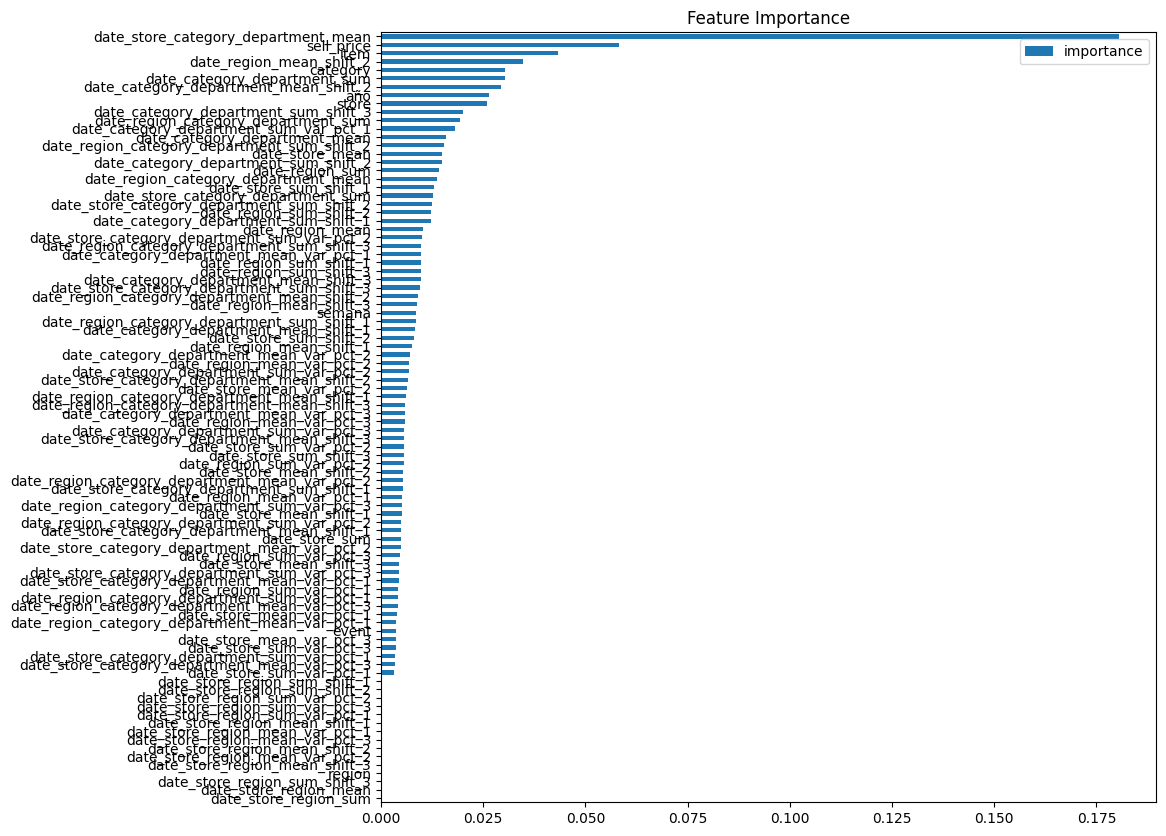

In [ ]:
fi.sort_values(by='importance').plot(kind='barh', figsize=(10, 10), title='Feature Importance')
plt.show()

###Evaluacion de Preduccion

In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 701270 entries, ACCESORIES_1_001_BOS_1 to SUPERMARKET_3_827_PHI_3
Data columns (total 92 columns):
 #   Column                                          Non-Null Count   Dtype  
---  ------                                          --------------   -----  
 0   item                                            701270 non-null  int16  
 1   category                                        701270 non-null  int8   
 2   store                                           701270 non-null  int8   
 3   region                                          701270 non-null  int8   
 4   event                                           701270 non-null  int8   
 5   semana                                          701270 non-null  Int8   
 6   año                                             701270 non-null  int16  
 7   sell_price                                      701270 non-null  float32
 8   date_store_sum                                  701270 non-null  float3

In [ ]:
if "ventas" in X_test.columns:
    X_test.drop("ventas", axis = 1, inplace = True)

Y_test_predict = model.predict(X_test)
X_test["ventas"] = Y_test_predict

In [ ]:
Y_test_predict

array([1.031226 , 2.068424 , 1.6159792, ..., 9.158749 , 5.5403657,
       0.5113022], dtype=float32)

In [ ]:
X_test.reset_index(inplace = True)

In [ ]:
X_test['ventas'].head(3)

,ventas
0,1.031226
1,2.068424
2,1.615979


In [ ]:
X_test_eval = X_test.copy()

In [ ]:
Y_test_eval.head()

,ventas
id,
ACCESORIES_1_001_BOS_1,2
ACCESORIES_1_001_BOS_1,2
ACCESORIES_1_002_BOS_1,0
ACCESORIES_1_002_BOS_1,0
ACCESORIES_1_003_BOS_1,1


In [ ]:
X_test_eval.head()

,id,item,category,store,region,event,semana,año,sell_price,date_store_sum,...,date_category_department_sum_var_pct_2,date_category_department_sum_shift_3,date_category_department_sum_var_pct_3,date_category_department_mean_shift_1,date_category_department_mean_var_pct_1,date_category_department_mean_shift_2,date_category_department_mean_var_pct_2,date_category_department_mean_shift_3,date_category_department_mean_var_pct_3,ventas
0,ACCESORIES_1_001_BOS_1,1,0,7,3,4,53,2015,10.99,41401.0,...,0.943617,24438.0,1.039692,5.439183,-0.265686,6.164904,-0.352128,5.874519,-0.320103,1.031226
1,ACCESORIES_1_001_BOS_1,1,0,7,3,0,53,2015,10.99,41401.0,...,0.943617,24438.0,1.039692,5.439183,-0.265686,6.164904,-0.352128,5.874519,-0.320103,2.068424
2,ACCESORIES_1_002_BOS_1,2,0,7,3,4,53,2015,5.28,41401.0,...,0.943617,24438.0,1.039692,5.439183,-0.265686,6.164904,-0.352128,5.874519,-0.320103,1.615979
3,ACCESORIES_1_002_BOS_1,2,0,7,3,0,53,2015,5.28,41401.0,...,0.943617,24438.0,1.039692,5.439183,-0.265686,6.164904,-0.352128,5.874519,-0.320103,4.143537
4,ACCESORIES_1_003_BOS_1,3,0,7,3,4,53,2015,3.95,41401.0,...,0.943617,24438.0,1.039692,5.439183,-0.265686,6.164904,-0.352128,5.874519,-0.320103,0.420074


In [ ]:
Y_test_eval.shape

(701270,)

In [ ]:
X_test_eval.shape

(701270, 94)

In [ ]:
# Asegurándote de que Y_test_eval es una Serie
Y_test_eval = Y_test_eval.reset_index(drop=True)

# Concatenar Y_test_eval como una nueva columna en X_test_eval
df_eval = pd.concat([X_test_eval.reset_index(drop=True), Y_test_eval], axis=1)

In [ ]:
df_eval.head(5)

,id,item,category,store,region,event,semana,año,sell_price,date_store_sum,...,date_category_department_sum_shift_3,date_category_department_sum_var_pct_3,date_category_department_mean_shift_1,date_category_department_mean_var_pct_1,date_category_department_mean_shift_2,date_category_department_mean_var_pct_2,date_category_department_mean_shift_3,date_category_department_mean_var_pct_3,ventas,ventas
0,ACCESORIES_1_001_BOS_1,1,0,7,3,4,53,2015,10.99,41401.0,...,24438.0,1.039692,5.439183,-0.265686,6.164904,-0.352128,5.874519,-0.320103,1.031226,2
1,ACCESORIES_1_001_BOS_1,1,0,7,3,0,53,2015,10.99,41401.0,...,24438.0,1.039692,5.439183,-0.265686,6.164904,-0.352128,5.874519,-0.320103,2.068424,2
2,ACCESORIES_1_002_BOS_1,2,0,7,3,4,53,2015,5.28,41401.0,...,24438.0,1.039692,5.439183,-0.265686,6.164904,-0.352128,5.874519,-0.320103,1.615979,0
3,ACCESORIES_1_002_BOS_1,2,0,7,3,0,53,2015,5.28,41401.0,...,24438.0,1.039692,5.439183,-0.265686,6.164904,-0.352128,5.874519,-0.320103,4.143537,0
4,ACCESORIES_1_003_BOS_1,3,0,7,3,4,53,2015,3.95,41401.0,...,24438.0,1.039692,5.439183,-0.265686,6.164904,-0.352128,5.874519,-0.320103,0.420074,1


In [ ]:
# Renombrar la columna de la serie (por ejemplo, a "ventas_y")
df_eval.columns = list(X_test_eval.columns) + ["ventas_reales"]
df_eval.rename(columns={'ventas': 'ventas_predict'}, inplace=True)
# Mostrar el dataframe
df_eval.head()

,id,item,category,store,region,event,semana,año,sell_price,date_store_sum,...,date_category_department_sum_shift_3,date_category_department_sum_var_pct_3,date_category_department_mean_shift_1,date_category_department_mean_var_pct_1,date_category_department_mean_shift_2,date_category_department_mean_var_pct_2,date_category_department_mean_shift_3,date_category_department_mean_var_pct_3,ventas_predict,ventas_reales
0,ACCESORIES_1_001_BOS_1,1,0,7,3,4,53,2015,10.99,41401.0,...,24438.0,1.039692,5.439183,-0.265686,6.164904,-0.352128,5.874519,-0.320103,1.031226,2
1,ACCESORIES_1_001_BOS_1,1,0,7,3,0,53,2015,10.99,41401.0,...,24438.0,1.039692,5.439183,-0.265686,6.164904,-0.352128,5.874519,-0.320103,2.068424,2
2,ACCESORIES_1_002_BOS_1,2,0,7,3,4,53,2015,5.28,41401.0,...,24438.0,1.039692,5.439183,-0.265686,6.164904,-0.352128,5.874519,-0.320103,1.615979,0
3,ACCESORIES_1_002_BOS_1,2,0,7,3,0,53,2015,5.28,41401.0,...,24438.0,1.039692,5.439183,-0.265686,6.164904,-0.352128,5.874519,-0.320103,4.143537,0
4,ACCESORIES_1_003_BOS_1,3,0,7,3,4,53,2015,3.95,41401.0,...,24438.0,1.039692,5.439183,-0.265686,6.164904,-0.352128,5.874519,-0.320103,0.420074,1


In [ ]:
df_eval.shape

(701270, 95)

In [ ]:
X_test_eval.head(3)

,id,item,category,store,region,event,semana,año,sell_price,date_store_sum,...,date_category_department_sum_var_pct_2,date_category_department_sum_shift_3,date_category_department_sum_var_pct_3,date_category_department_mean_shift_1,date_category_department_mean_var_pct_1,date_category_department_mean_shift_2,date_category_department_mean_var_pct_2,date_category_department_mean_shift_3,date_category_department_mean_var_pct_3,ventas
0,ACCESORIES_1_001_BOS_1,1,0,7,3,4,53,2015,10.99,41401.0,...,0.943617,24438.0,1.039692,5.439183,-0.265686,6.164904,-0.352128,5.874519,-0.320103,1.031226
1,ACCESORIES_1_001_BOS_1,1,0,7,3,0,53,2015,10.99,41401.0,...,0.943617,24438.0,1.039692,5.439183,-0.265686,6.164904,-0.352128,5.874519,-0.320103,2.068424
2,ACCESORIES_1_002_BOS_1,2,0,7,3,4,53,2015,5.28,41401.0,...,0.943617,24438.0,1.039692,5.439183,-0.265686,6.164904,-0.352128,5.874519,-0.320103,1.615979


In [ ]:
df_eval["error"] = df_eval["ventas_predict"] -  df_eval["ventas_reales"]

In [ ]:
df_eval["error"].mean()# de media, el modelo a predicho las ventas con un error del 0.37

0.37998894

In [ ]:
Y_train_predict = model.predict(X_train)
Y_valida_predict = model.predict(X_valida)

rmse_train = np.sqrt(
    mean_squared_error(
        y_true = Y_train,
        y_pred = Y_train_predict
    )
)

rmse_valida = np.sqrt(
    mean_squared_error(
        y_true = Y_valida,
        y_pred = Y_valida_predict
    )
)

rmse_train= (round(rmse_train, 3))
rmse_test = (round(rmse_valida, 3))

In [ ]:
print(f"Train RMSE: {rmse_train}")
print(f"Validation RMSE: {rmse_valida}")

Train RMSE: 9.621000289916992
Validation RMSE: 13.032488822937012


In [ ]:
df_it_st3["ventas"].mean()

7.27923743274268

## Graficas de validacion de la prediccion

In [ ]:
df_eval['yearweek'] = df_eval['año'].astype(str) + '-' + df_eval['semana'].astype(str).str.zfill(2)
df_eval['date'] = pd.to_datetime(df_eval['yearweek'] + '-1', format='%Y-%W-%w')

In [ ]:
df_eval.set_index("date", inplace = True)

In [ ]:
df_eval.tail()

,id,item,category,store,region,event,semana,año,sell_price,date_store_sum,...,date_category_department_mean_shift_1,date_category_department_mean_var_pct_1,date_category_department_mean_shift_2,date_category_department_mean_var_pct_2,date_category_department_mean_shift_3,date_category_department_mean_var_pct_3,ventas_predict,ventas_reales,error,yearweek
date,,,,,,,,,,,,,,,,,,,,,
2016-05-16,SUPERMARKET_3_827_PHI_2,827,2,5,2,0,20,2016,1.2,0.0,...,0.000000,-1.0,0.000000,-1.0,0.000000,-1.0,0.052327,0,0.052327,2016-20
2016-04-25,SUPERMARKET_3_827_PHI_3,827,2,6,2,0,17,2016,1.2,0.0,...,16.114944,-1.0,16.827826,-1.0,17.378494,-1.0,9.975016,0,9.975016,2016-17
2016-05-02,SUPERMARKET_3_827_PHI_3,827,2,6,2,0,18,2016,1.2,0.0,...,0.000000,-1.0,16.114944,-1.0,16.827826,-1.0,9.158749,0,9.158749,2016-18
2016-05-09,SUPERMARKET_3_827_PHI_3,827,2,6,2,0,19,2016,1.2,0.0,...,0.000000,-1.0,0.000000,-1.0,16.114944,-1.0,5.540366,0,5.540366,2016-19
2016-05-16,SUPERMARKET_3_827_PHI_3,827,2,6,2,0,20,2016,1.2,0.0,...,0.000000,-1.0,0.000000,-1.0,0.000000,-1.0,0.511302,0,0.511302,2016-20


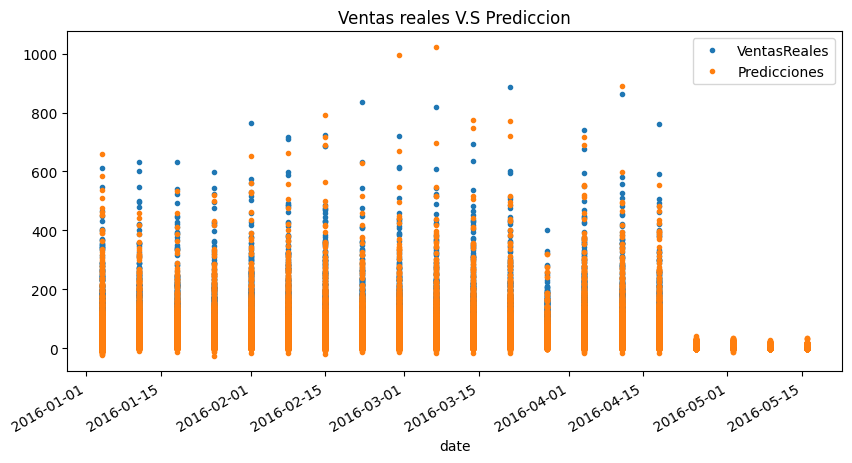

In [ ]:
ax = df_eval[["ventas_reales"]].plot(figsize=(10, 5), style=".", label="Ventas Reales")
df_eval["ventas_predict"].plot(ax=ax, style=".", label="Predicciones")
plt.legend(["VentasReales","Predicciones"])
ax.set_title("Ventas reales V.S Prediccion")
plt.show()

In [ ]:
# Creamos un Dataframe exclusivo para realizar los graficos de dispersion y el histograma de residuos
validacion_pred = pd.DataFrame({
    'Ventas Actuales': Y_valida,
    'Ventas Prediccion': Y_valida_predict
})

validacion_pred['Residuos'] = validacion_pred['Ventas Actuales'] - validacion_pred['Ventas Prediccion']
validacion_pred.head()

,Ventas Actuales,Ventas Prediccion,Residuos
id,,,
ACCESORIES_1_001_BOS_1,0,1.060849,-1.060849
ACCESORIES_1_001_BOS_1,1,0.509100,0.490900
ACCESORIES_1_002_BOS_1,0,1.436260,-1.436260
ACCESORIES_1_002_BOS_1,2,0.663306,1.336694
ACCESORIES_1_003_BOS_1,1,0.749071,0.250929


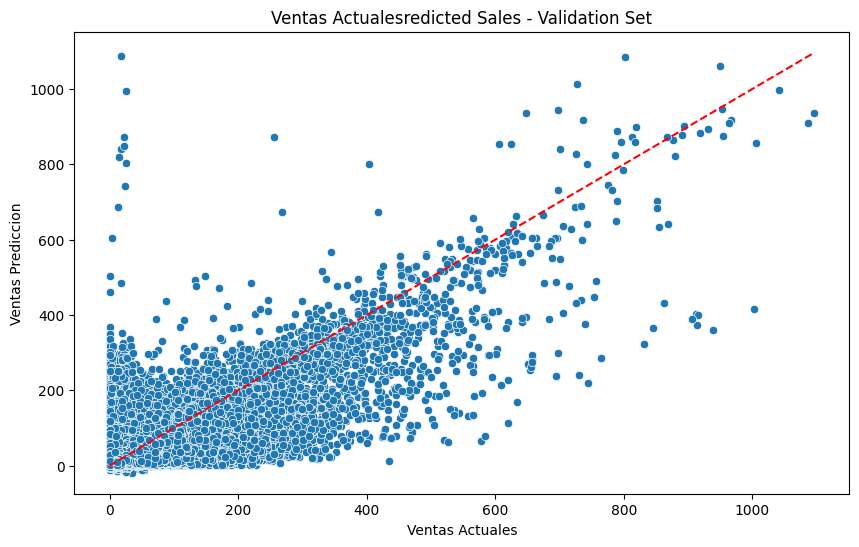

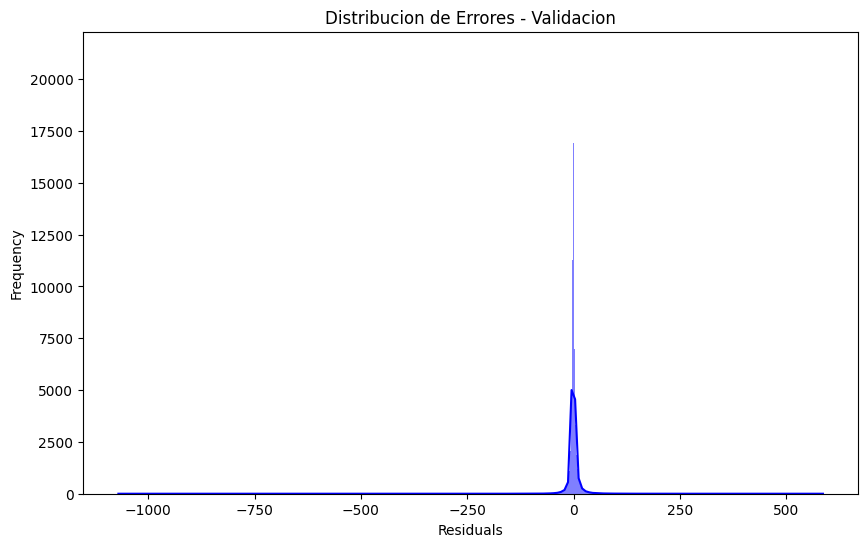

In [ ]:
# Gráfico de dispersión de las predicciones vs valores reales
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Ventas Actuales', y='Ventas Prediccion', data=validacion_pred)
plt.plot([validacion_pred['Ventas Actuales'].min(), validacion_pred['Ventas Actuales'].max()],
         [validacion_pred['Ventas Actuales'].min(), validacion_pred['Ventas Actuales'].max()],
         color='red', linestyle='--')  # Línea de perfecta predicción
plt.title('Ventas Actualesredicted Sales - Validation Set')
plt.xlabel('Ventas Actuales')
plt.ylabel('Ventas Prediccion')
plt.show()

# Histograma de residuos
plt.figure(figsize=(10, 6))
sns.histplot(validacion_pred['Residuos'], kde=True, color='blue')
plt.title('Distribucion de Errores - Validacion')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

## Prediccion de los siguiente 28 días (4 semanas)

###Generamos un dataset para graficar la prediccion



In [ ]:
df_eval

,id,item,category,store,region,event,semana,año,sell_price,date_store_sum,...,date_category_department_mean_shift_1,date_category_department_mean_var_pct_1,date_category_department_mean_shift_2,date_category_department_mean_var_pct_2,date_category_department_mean_shift_3,date_category_department_mean_var_pct_3,ventas_predict,ventas_reales,error,yearweek
date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,ACCESORIES_1_001_BOS_1,1,0,7,3,4,53,2015,10.99,41401.0,...,5.439183,-0.265686,6.164904,-0.352128,5.874519,-0.320103,1.031226,2,-0.968774,2015-53
2016-01-04,ACCESORIES_1_001_BOS_1,1,0,7,3,0,53,2015,10.99,41401.0,...,5.439183,-0.265686,6.164904,-0.352128,5.874519,-0.320103,2.068424,2,0.068424,2015-53
2016-01-04,ACCESORIES_1_002_BOS_1,2,0,7,3,4,53,2015,5.28,41401.0,...,5.439183,-0.265686,6.164904,-0.352128,5.874519,-0.320103,1.615979,0,1.615979,2015-53
2016-01-04,ACCESORIES_1_002_BOS_1,2,0,7,3,0,53,2015,5.28,41401.0,...,5.439183,-0.265686,6.164904,-0.352128,5.874519,-0.320103,4.143537,0,4.143537,2015-53
2016-01-04,ACCESORIES_1_003_BOS_1,3,0,7,3,4,53,2015,3.95,41401.0,...,5.439183,-0.265686,6.164904,-0.352128,5.874519,-0.320103,0.420074,1,-0.579926,2015-53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-16,SUPERMARKET_3_827_PHI_2,827,2,5,2,0,20,2016,1.20,0.0,...,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.052327,0,0.052327,2016-20
2016-04-25,SUPERMARKET_3_827_PHI_3,827,2,6,2,0,17,2016,1.20,0.0,...,16.114944,-1.000000,16.827826,-1.000000,17.378494,-1.000000,9.975016,0,9.975016,2016-17
2016-05-02,SUPERMARKET_3_827_PHI_3,827,2,6,2,0,18,2016,1.20,0.0,...,0.000000,-1.000000,16.114944,-1.000000,16.827826,-1.000000,9.158749,0,9.158749,2016-18


In [ ]:
df_eval.reset_index(inplace = True)

In [ ]:
columns=['id', 'item', 'category', 'store', 'region', 'event',
       'semana', 'año','date', 'sell_price', 'ventas_predict', 'ventas_reales']

In [ ]:
# Creamos el Dataset de mayo con sus predicciones.
df_4weeks = df_eval[columns][df_eval['date'] >= '2016-04-25']

In [ ]:
df_4weeks

,id,item,category,store,region,event,semana,año,date,sell_price,ventas_predict,ventas_reales
579310,ACCESORIES_1_001_BOS_1,1,0,7,3,0,17,2016,2016-04-25,10.99,0.467076,0
579311,ACCESORIES_1_001_BOS_1,1,0,7,3,0,18,2016,2016-05-02,10.99,0.692498,0
579312,ACCESORIES_1_001_BOS_1,1,0,7,3,0,19,2016,2016-05-09,10.99,0.563528,0
579313,ACCESORIES_1_001_BOS_1,1,0,7,3,0,20,2016,2016-05-16,10.99,0.394512,0
579314,ACCESORIES_1_001_BOS_2,1,0,8,3,0,17,2016,2016-04-25,10.99,0.527204,0
...,...,...,...,...,...,...,...,...,...,...,...,...
701265,SUPERMARKET_3_827_PHI_2,827,2,5,2,0,20,2016,2016-05-16,1.20,0.052327,0
701266,SUPERMARKET_3_827_PHI_3,827,2,6,2,0,17,2016,2016-04-25,1.20,9.975016,0
701267,SUPERMARKET_3_827_PHI_3,827,2,6,2,0,18,2016,2016-05-02,1.20,9.158749,0
701268,SUPERMARKET_3_827_PHI_3,827,2,6,2,0,19,2016,2016-05-09,1.20,5.540366,0


In [ ]:
df_4weeks[df_4weeks['id']=='ACCESORIES_1_001_BOS_1']

,id,item,category,store,region,event,semana,año,date,sell_price,ventas_predict,ventas_reales
579310,ACCESORIES_1_001_BOS_1,1,0,7,3,0,17,2016,2016-04-25,10.99,0.467076,0
579311,ACCESORIES_1_001_BOS_1,1,0,7,3,0,18,2016,2016-05-02,10.99,0.692498,0
579312,ACCESORIES_1_001_BOS_1,1,0,7,3,0,19,2016,2016-05-09,10.99,0.563528,0
579313,ACCESORIES_1_001_BOS_1,1,0,7,3,0,20,2016,2016-05-16,10.99,0.394512,0


### Se transforman las variables para ser mas legibles

In [ ]:
# Creamos Datasets con las prediciones y valores reales del mes de Abril para tomar de referencia en la calidad de nuestro modelo

ventas_abril = df_eval[df_eval['date'].dt.month == 4]

# Primero vamos a agrupar las ventas reales por las variables que utilizaremos para el control de la prediccion
ventas_por_categoria_abril = ventas_abril.groupby('category')['ventas_reales'].sum().reset_index()
ventas_por_region_abril = ventas_abril.groupby('region')['ventas_reales'].sum().reset_index()
ventas_por_tienda_abril = ventas_abril.groupby('store')['ventas_reales'].sum().reset_index()

# Luego hacemos lo mismo que anteriormente pero con las ventas que hemos predecido
pred_por_categoria_abril = ventas_abril.groupby('category')['ventas_predict'].sum().reset_index()
pred_por_region_abril = ventas_abril.groupby('region')['ventas_predict'].sum().reset_index()
pred_por_store_abril = ventas_abril.groupby('store')['ventas_predict'].sum().reset_index()

# Por ultimo, hacemos un merge de lo que hemos creado para poder visualizarlo en graficos
merged_df = pd.merge(pred_por_categoria_abril, ventas_por_categoria_abril, on='category', suffixes=('_predict', '_reales'))
merged_df_region = pd.merge(pred_por_region_abril, ventas_por_region_abril, on='region', suffixes=('_predict', '_reales'))
merged_df_store = pd.merge(pred_por_store_abril, ventas_por_tienda_abril, on='store', suffixes=('_predict', '_reales'))

# El ultimo paso es crear la variable de la diferencia entre lo predecido y las ventas reales.
merged_df['diferencia'] = merged_df['ventas_predict'] - merged_df['ventas_reales']
merged_df_region['diferencia'] = merged_df_region['ventas_predict'] - merged_df_region['ventas_reales']
merged_df_store['diferencia'] = merged_df_store['ventas_predict'] - merged_df_store['ventas_reales']

In [ ]:
# Hardcodeamos las variables de nuevo para hecer más entendible los graficos que haremos a continuacion
# Definir el mapeo manual
region_mapping = {
    1: 'New York',
    2: 'Philadelphia',
    3: 'Boston'
}

# Asignar el orden numérico manualmente
df_4weeks['region'] = df_4weeks['region'].map(region_mapping).astype("str")
merged_df_region['region'] = merged_df_region['region'].map(region_mapping).astype("str")

In [ ]:
# Definir el mapeo manual
store_mapping = {
    0: 'Greenwich_Village',
    1: 'Harlem',
    2: 'Tribeca',
    3: 'Brooklyn',
    4: 'Midtown_Village',
    5: 'Yorktown',
    6: 'Queen_Village',
    7: 'South_End',
    8: 'Roxbury',
    9: 'Back_Bay'
}

# Asignar el orden numérico manualmente a la columna 'store'
df_4weeks['store'] = df_4weeks['store'].map(store_mapping).astype("str")
merged_df_store['store'] = merged_df_store['store'].map(store_mapping).astype("str")


In [ ]:
# Definir el mapeo manual
dptm_mapping = {
    0 : 'ACCESORIES',
    1 : 'HOME_&_GARDEN',
    2 : 'SUPERMARKET'

}

# Asignar el orden numérico manualmente a la columna 'category'
df_4weeks['category'] = df_4weeks['category'].map(dptm_mapping).astype("str")
merged_df['category'] = merged_df['category'].map(dptm_mapping).astype("str")

In [ ]:
# Definir el mapeo manual
eve_mapping = {
    0 : 'Sin_Evento',
    1 : 'SuperBowl',
    2 : 'Ramadan starts',
    3 : 'Thanksgiving',
    4 : 'NewYear',
    5 : 'Easter'
}

# Asignar el orden numérico manualmente a la columna 'event'
df_4weeks['event'] = df_4weeks['event'].map(eve_mapping).astype("str")

In [ ]:
df_4weeks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 121960 entries, 579310 to 701269
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   id              121960 non-null  object        
 1   item            121960 non-null  int16         
 2   category        121960 non-null  object        
 3   store           121960 non-null  object        
 4   region          121960 non-null  object        
 5   event           121960 non-null  object        
 6   semana          121960 non-null  Int8          
 7   año             121960 non-null  int16         
 8   date            121960 non-null  datetime64[ns]
 9   sell_price      121960 non-null  float32       
 10  ventas_predict  121960 non-null  float32       
 11  ventas_reales   121960 non-null  int16         
dtypes: Int8(1), datetime64[ns](1), float32(2), int16(3), object(5)
memory usage: 8.4+ MB


### Representacion de las predicciones

In [ ]:
df_4weeks.groupby(['store','date'])['ventas_predict'].sum()

store              date      
Back_Bay           2016-04-25    4472.498535
                   2016-05-02    3872.975098
                   2016-05-09    2981.906982
                   2016-05-16    1766.253296
Brooklyn           2016-04-25    4274.937500
                   2016-05-02    3552.175781
                   2016-05-09    2913.823730
                   2016-05-16    1970.734741
Greenwich_Village  2016-04-25    5187.450195
                   2016-05-02    4173.489746
                   2016-05-09    3626.877441
                   2016-05-16    2158.721924
Harlem             2016-04-25    5235.046875
                   2016-05-02    4270.561035
                   2016-05-09    3508.594238
                   2016-05-16    2142.458740
Midtown_Village    2016-04-25    4576.979004
                   2016-05-02    4052.358887
                   2016-05-09    3117.968262
                   2016-05-16    2021.815552
Queen_Village      2016-04-25    4576.832520
                   2016-05-02    3843.695068
                   2016-05-09    2928.146240
                   2016-05-16    1685.126953
Roxbury            2016-04-25    4422.318359
                   2016-05-02    3883.832275
                   2016-05-09    2896.294678
                   2016-05-16    1750.672852
South_End          2016-04-25    4125.135742
                   2016-05-02    3535.759766
                   2016-05-09    2778.808594
                   2016-05-16    1701.648438
Tribeca            2016-04-25    5963.611328
                   2016-05-02    4339.172363
                   2016-05-09    3656.041016
                   2016-05-16    2075.679932
Yorktown           2016-04-25    4839.875488
                   2016-05-02    3972.726074
                   2016-05-09    2920.200928
                   2016-05-16    1643.831665
Name: ventas_predict, dtype: float32

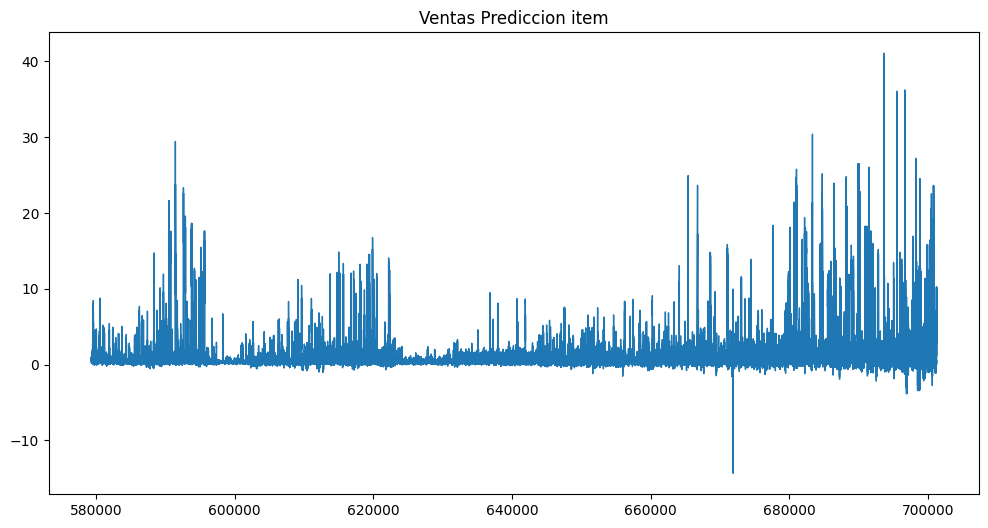

In [ ]:
df_4weeks["ventas_predict"].plot(figsize=(12, 6),
                                 ms=1,
                                 lw=1, title="Ventas Prediccion item")
plt.show()

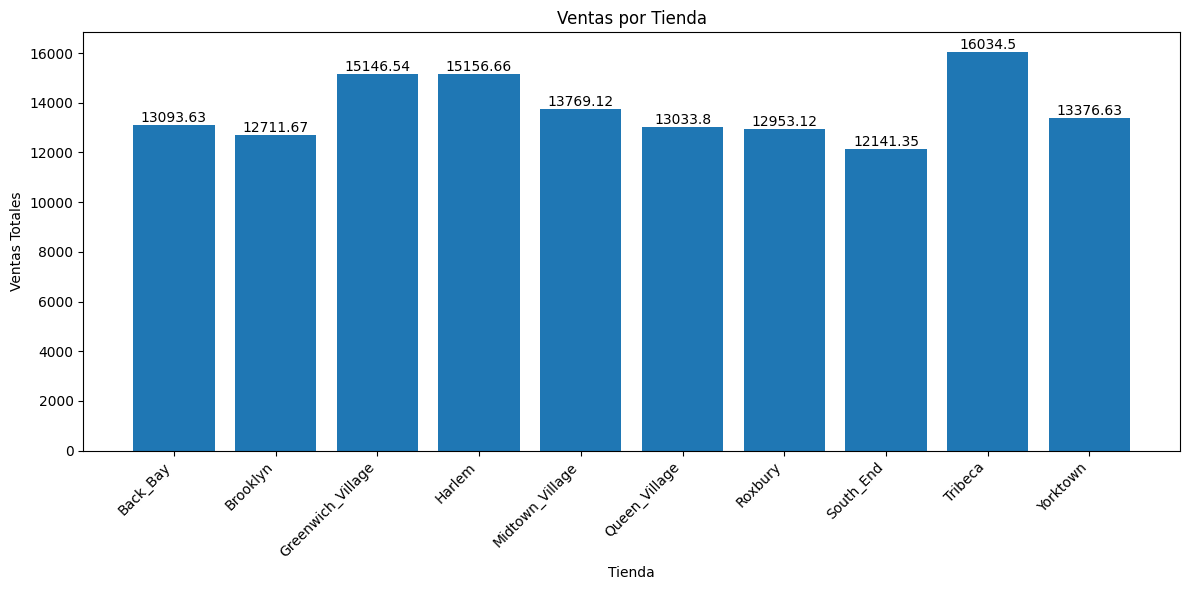

In [ ]:
# Agrupar las ventas por tienda y sumarlas
ventas_por_tienda = df_4weeks.groupby('store')['ventas_predict'].sum()

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
bars = plt.bar(ventas_por_tienda.index, ventas_por_tienda.values)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', fontsize=10)

plt.xlabel('Tienda')
plt.ylabel('Ventas Totales')
plt.title('Ventas por Tienda')
plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas del eje x para una mejor legibilidad
plt.tight_layout()  # Ajustar el diseño del gráfico
plt.show()


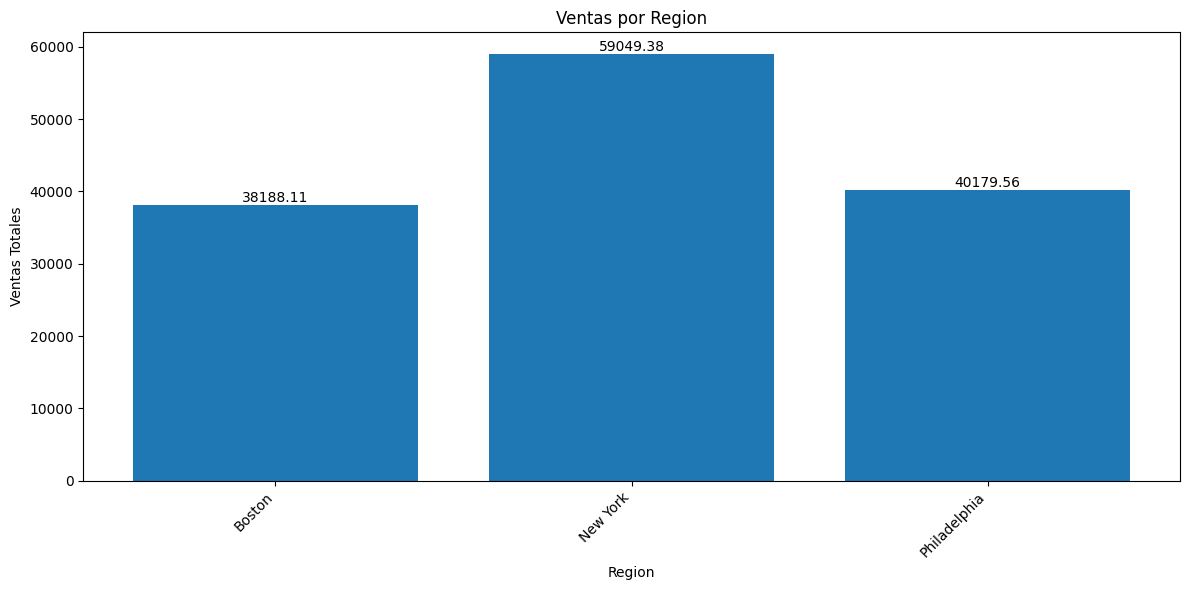

In [ ]:
# Agrupar las ventas por Region y sumarlas
ventas_por_region = df_4weeks.groupby('region')['ventas_predict'].sum()

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
bars = plt.bar(ventas_por_region.index, ventas_por_region.values)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', fontsize=10)

plt.xlabel('Region')
plt.ylabel('Ventas Totales')
plt.title('Ventas por Region')
plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas del eje x para una mejor legibilidad
plt.tight_layout()  # Ajustar el diseño del gráfico
plt.show()


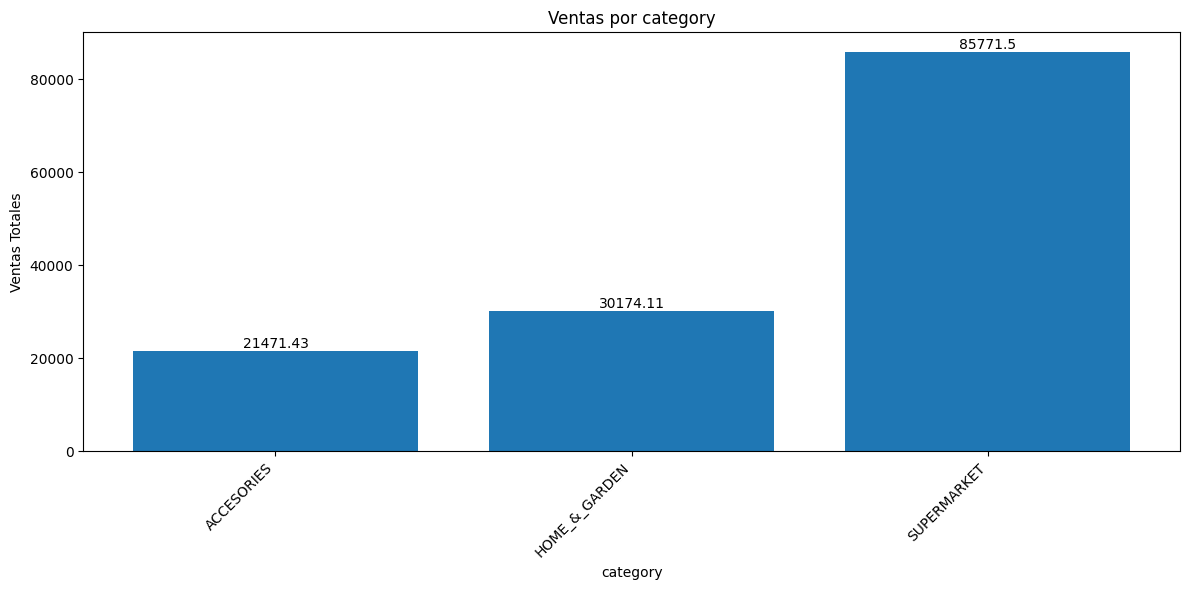

In [ ]:
# Agrupar las ventas por category y sumarlas
ventas_por_category = df_4weeks.groupby('category')['ventas_predict'].sum()

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
bars = plt.bar(ventas_por_category.index, ventas_por_category.values)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', fontsize=10)

plt.xlabel('category')
plt.ylabel('Ventas Totales')
plt.title('Ventas por category')
plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas del eje x para una mejor legibilidad
plt.tight_layout()  # Ajustar el diseño del gráfico
plt.show()


In [ ]:
df_4weeks.set_index("date", inplace = True)

In [ ]:
columns=['id', 'item', 'category', 'department', 'store', 'region', 'event',
       'semana', 'trimestre', 'año','date', 'sell_price', 'ventas_predict', 'ventas_reales']

In [ ]:
df_4weeks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121960 entries, 2016-04-25 to 2016-05-16
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              121960 non-null  object 
 1   item            121960 non-null  int16  
 2   category        121960 non-null  object 
 3   store           121960 non-null  object 
 4   region          121960 non-null  object 
 5   event           121960 non-null  object 
 6   semana          121960 non-null  Int8   
 7   año             121960 non-null  int16  
 8   sell_price      121960 non-null  float32
 9   ventas_predict  121960 non-null  float32
 10  ventas_reales   121960 non-null  int16  
dtypes: Int8(1), float32(2), int16(3), object(5)
memory usage: 7.4+ MB


In [ ]:
df_4weeks

,id,item,category,store,region,event,semana,año,sell_price,ventas_predict,ventas_reales
date,,,,,,,,,,,
2016-04-25,ACCESORIES_1_001_BOS_1,1,ACCESORIES,South_End,Boston,Sin_Evento,17,2016,10.99,0.467076,0
2016-05-02,ACCESORIES_1_001_BOS_1,1,ACCESORIES,South_End,Boston,Sin_Evento,18,2016,10.99,0.692498,0
2016-05-09,ACCESORIES_1_001_BOS_1,1,ACCESORIES,South_End,Boston,Sin_Evento,19,2016,10.99,0.563528,0
2016-05-16,ACCESORIES_1_001_BOS_1,1,ACCESORIES,South_End,Boston,Sin_Evento,20,2016,10.99,0.394512,0
2016-04-25,ACCESORIES_1_001_BOS_2,1,ACCESORIES,Roxbury,Boston,Sin_Evento,17,2016,10.99,0.527204,0
...,...,...,...,...,...,...,...,...,...,...,...
2016-05-16,SUPERMARKET_3_827_PHI_2,827,SUPERMARKET,Yorktown,Philadelphia,Sin_Evento,20,2016,1.20,0.052327,0
2016-04-25,SUPERMARKET_3_827_PHI_3,827,SUPERMARKET,Queen_Village,Philadelphia,Sin_Evento,17,2016,1.20,9.975016,0
2016-05-02,SUPERMARKET_3_827_PHI_3,827,SUPERMARKET,Queen_Village,Philadelphia,Sin_Evento,18,2016,1.20,9.158749,0


In [ ]:
df_4weeks.reset_index(inplace = True)

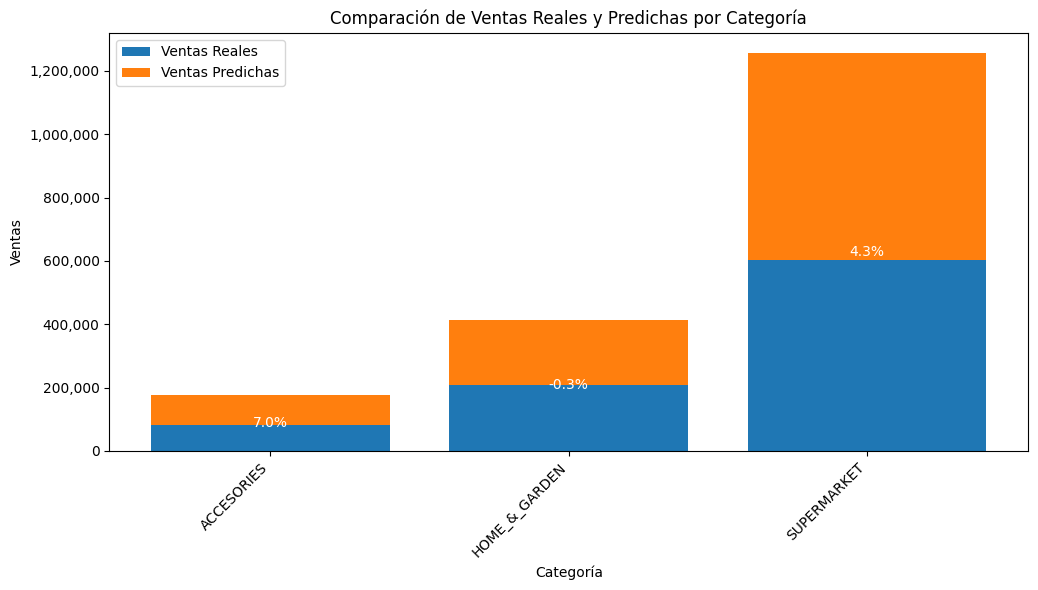

In [ ]:

# Crear el gráfico de barras apiladas
fig, ax = plt.subplots(figsize=(10, 6))

# Barras para las ventas reales
ax.bar(merged_df['category'], merged_df['ventas_reales'], label='Ventas Reales')

# Barras para las ventas predichas (apiladas sobre las reales)
ax.bar(merged_df['category'], merged_df['ventas_predict'], bottom=merged_df['ventas_reales'], label='Ventas Predichas')

# Añadir etiquetas con el porcentaje de diferencia
for i, row in merged_df.iterrows():
    total_ventas = row['ventas_reales'] + row['ventas_predict']
    diferencia_porcentaje = (row['diferencia'] / total_ventas) * 100
    ax.text(i, total_ventas / 2, f"{diferencia_porcentaje:.1f}%", ha='center', va='center', color='white')

# Configurar el gráfico
ax.set_xlabel('Categoría')
ax.set_ylabel('Ventas')
ax.set_title('Comparación de Ventas Reales y Predichas por Categoría')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.show()


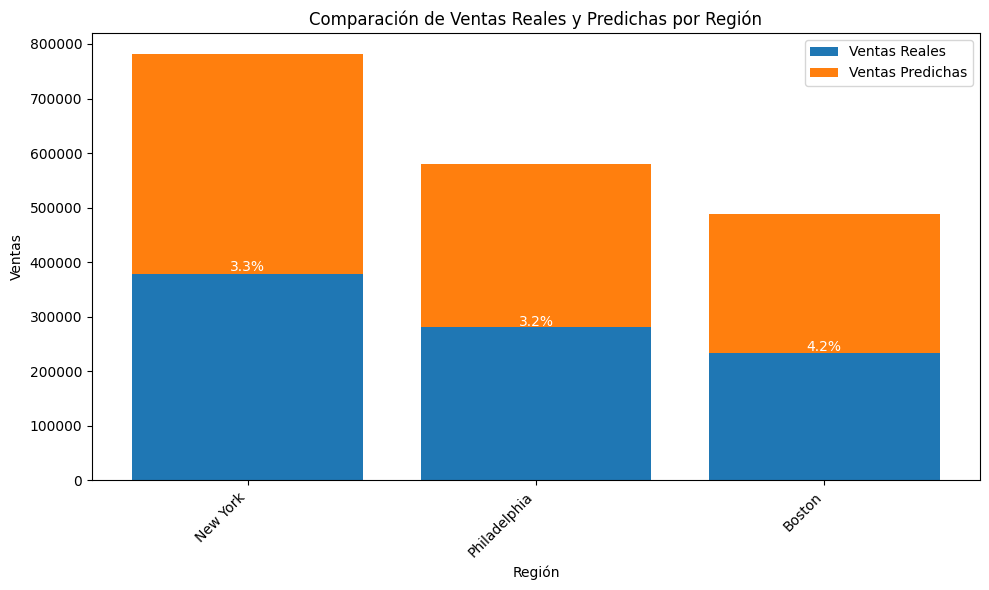

In [ ]:
# Crear el gráfico de barras apiladas
fig, ax = plt.subplots(figsize=(10, 6))

# Barras para las ventas reales
ax.bar(merged_df_region['region'], merged_df_region['ventas_reales'], label='Ventas Reales')
# Barras para las ventas predichas (apiladas sobre las reales)
ax.bar(merged_df_region['region'], merged_df_region['ventas_predict'], bottom=merged_df_region['ventas_reales'], label='Ventas Predichas')

# Añadir etiquetas con el porcentaje de diferencia
for i, row in merged_df_region.iterrows():
    total_ventas = row['ventas_reales'] + row['ventas_predict']
    diferencia_porcentaje = (row['diferencia'] / total_ventas) * 100
    ax.text(i, total_ventas / 2, f"{diferencia_porcentaje:.1f}%", ha='center', va='center', color='white')

# Configurar el gráfico
ax.set_xlabel('Región')
ax.set_ylabel('Ventas')
ax.set_title('Comparación de Ventas Reales y Predichas por Región')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


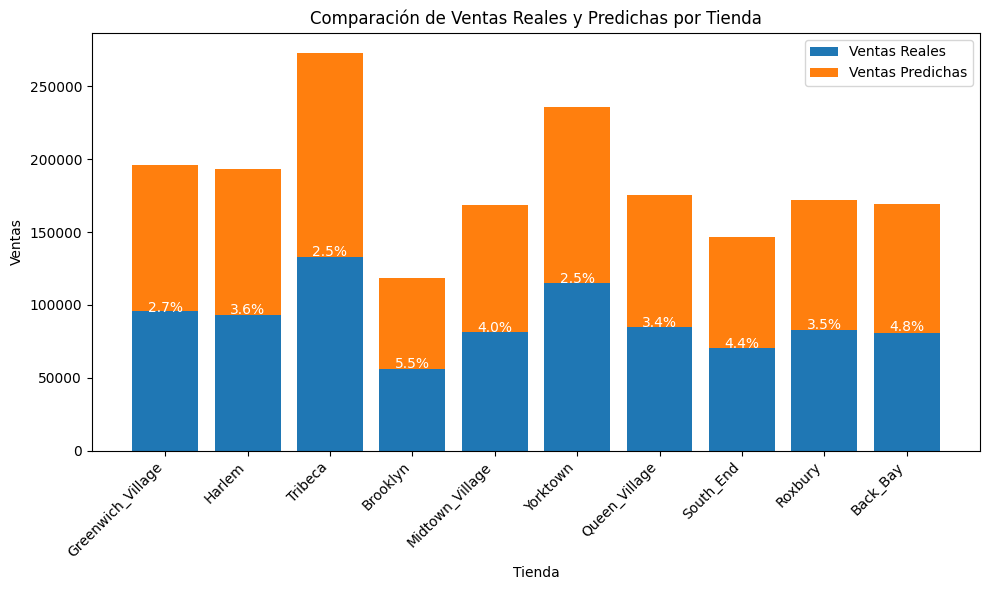

In [ ]:

# Crear el gráfico de barras apiladas
fig, ax = plt.subplots(figsize=(10, 6))

# Barras para las ventas reales
ax.bar(merged_df_store['store'], merged_df_store['ventas_reales'], label='Ventas Reales')

# Barras para las ventas predichas (apiladas sobre las reales)
ax.bar(merged_df_store['store'], merged_df_store['ventas_predict'], bottom=merged_df_store['ventas_reales'], label='Ventas Predichas')

# Añadir etiquetas con el porcentaje de diferencia
for i, row in merged_df_store.iterrows():
    total_ventas = row['ventas_reales'] + row['ventas_predict']
    diferencia_porcentaje = (row['diferencia'] / total_ventas) * 100
    ax.text(i, total_ventas / 2, f"{diferencia_porcentaje:.1f}%", ha='center', va='center', color='white')

# Configurar el gráfico
ax.set_xlabel('Tienda')
ax.set_ylabel('Ventas')
ax.set_title('Comparación de Ventas Reales y Predichas por Tienda')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Del dataset de prediciones mayo extraemos el total de ventas por region
total_ventas_por_region_mayo = df_4weeks.groupby('region')['ventas_predict'].sum()

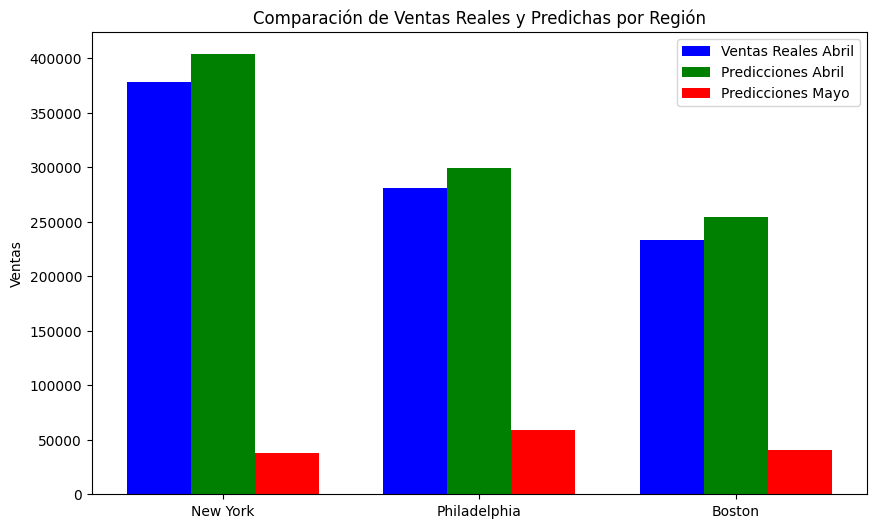

In [ ]:

# Datos para el gráfico
regions = ['New York', 'Philadelphia', 'Boston']
real_sales =  merged_df_region['ventas_reales'].tolist()
predicted_sales_april = merged_df_region['ventas_predict'].tolist()
predicted_sales_may = total_ventas_por_region_mayo.tolist()

# Crear el gráfico de barras
x = range(len(regions))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x, real_sales, width, color='blue', label='Ventas Reales Abril')
rects2 = ax.bar([i + width for i in x], predicted_sales_april, width, color='green', label='Predicciones Abril')
rects3 = ax.bar([i + width * 2 for i in x], predicted_sales_may, width, color='red', label='Predicciones Mayo')


# Configurar el gráfico
ax.set_ylabel('Ventas')
ax.set_title('Comparación de Ventas Reales y Predichas por Región')
ax.set_xticks([i + width for i in x])
ax.set_xticklabels(regions)
plt.legend()
plt.show()
